###Drive code

In [ ]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.171.0
    Uninstalling google-api-python-client-2.171.0:
      Successfully uninstalled google-api-python-client-2.171.0


In [ ]:
https://drive.google.com/file/d/1ACi2oPMVEf_FKGescdSY46KNkn0Sb_qO/view?usp=drive_link

##Here we directly download the embeddings (already tuned in the previous notebook)

In [ ]:
import os
import io
import shutil
from google.colab import auth
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload

# Authenticate and initialize the Drive API
auth.authenticate_user()

from google.auth import default
creds, _ = default()

drive_service = build('drive', 'v3', credentials=creds)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
from google.colab import drive


In [ ]:
from google.colab import auth
from googleapiclient.discovery import build
import io
import pandas as pd

# Authenticate
auth.authenticate_user()

# Build service
drive_service = build('drive', 'v3')

# Download function
def download_file(file_id):
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
        status, done = downloader.next_chunk()
        print(f"Download {int(status.progress() * 100)}%")

    fh.seek(0)
    return fh

# Your file ID
file_id = '1ACi2oPMVEf_FKGescdSY46KNkn0Sb_qO'
file_handle = download_file(file_id)

# Load data
try:
    df = pd.read_csv(file_handle)  # or read_excel()
    print("Successfully loaded file:")
    print(df.head())
except Exception as e:
    print(f"Error loading file: {e}")

Download 37%
Download 74%
Download 100%
Successfully loaded file:
          0         1         2         3         4         5         6  \
0 -0.219889 -0.321797  0.263243 -0.340925  0.874171  0.425958 -0.253462   
1  0.093033 -0.182951  0.336277 -0.446921  0.830442  0.180694 -0.094266   
2  0.222661  0.267904 -0.100978  0.190534 -0.610882 -0.963068  0.190430   
3  0.161619  0.298373 -0.069660  0.252373 -0.614083 -0.914570  0.198626   
4 -0.111615 -0.331747  0.412686 -0.467817  0.828353  0.399464 -0.418630   

          7         8         9  ...       760       761       762       763  \
0  0.422493 -0.090833 -0.489971  ...  0.641233 -0.987703  0.628936 -0.524079   
1  0.202616  0.024229 -0.480650  ...  0.534885 -1.056066  0.519490 -0.239282   
2  0.521837  0.195717  0.795336  ... -0.811272  0.424921 -0.689908  0.724783   
3  0.435958  0.192959  0.740141  ... -0.847160  0.470795 -0.649935  0.828252   
4  0.160537 -0.191338 -0.271206  ...  0.713990 -0.880397  0.682753 -0.296433   

  

In [ ]:
df['label'].value_counts()

,count
label,
0,24639
1,8197


In [ ]:

X = df.iloc[:, :768]
y = df.iloc[:, 769:]
uids = df.iloc[:, 768]

In [ ]:
uids

,uid
0,721
1,22206
2,9360
3,21019
4,3890
...,...
32831,13832
32832,8530
32833,24093
32834,10221


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test, uids_trainval, uids_test = train_test_split(
    X, y, uids,
    test_size=0.20,
    stratify=y,          # preserve fraud/non‐fraud ratio
    random_state=42
)

X_train, X_val, y_train, y_val, uids_train, uids_val = train_test_split(
    X_trainval, y_trainval, uids_trainval,
    test_size=0.1875,    # 0.1875 * 0.80 ≈ 0.15 of original
    stratify=y_trainval,
    random_state=42
)

In [ ]:
y_train.value_counts()


,count
label,
0,16015
1,5327


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# fit only on your training split!
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled  = scaler.transform(X_test)


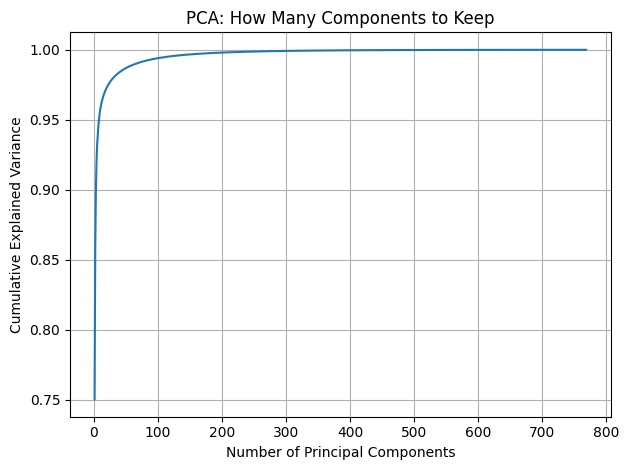

In [ ]:
# — 2. Fit PCA
pca = PCA(n_components=X_train_scaled.shape[1])
pca.fit(X_train_scaled)

# — 3. Compute and plot cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(np.arange(1, len(cum_var)+1), cum_var)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: How Many Components to Keep')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=70, whiten=True)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [ ]:
uids_train = uids_train.to_numpy()
uids_val = uids_val.to_numpy()
uids_test = uids_test.to_numpy()

In [ ]:
X_train_pca.shape

(21342, 70)

In [ ]:
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 89.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [ ]:
from ctgan import CTGAN
import pandas as pd
import numpy as np

# 1. Build a DataFrame of your PCA embeddings + labels
df_pca = pd.DataFrame(
    X_train_pca,
    columns=[f"pc{i+1}" for i in range(X_train_pca.shape[1])]
)
df_pca['label'] = y_train.values.ravel()

# 2. Extract only the minority class (fraud = 1) embeddings
minority_df = df_pca[df_pca['label'] == 1].drop('label', axis=1)

# 3. Initialize and fit CTGAN with pac=1 to disable PacGAN grouping
ctgan = CTGAN(epochs=200, batch_size=64, pac=1)
ctgan.fit(minority_df)

# 4. Sample synthetic fraud embeddings (same count as real fraud instances)
n_syn = len(minority_df)
syn_df = ctgan.sample(n_syn)

# 5. Convert synthetic DataFrame back to numpy arrays
syn_embeddings = syn_df.values.astype(np.float32)
syn_labels     = np.ones(n_syn, dtype=np.int64)

# 6. Augment your training set
X_train_aug = np.vstack([X_train_pca, syn_embeddings])
y_train_aug = np.concatenate([y_train.values.ravel(), syn_labels])

# 7. Check shapes
print(f"Original fraud count: {n_syn}, Synthetic added: {n_syn}")
print(f"Augmented X_train shape: {X_train_aug.shape}")
print(f"Augmented y_train shape: {y_train_aug.shape}")

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Original fraud count: 5327, Synthetic added: 5327
Augmented X_train shape: (26669, 70)
Augmented y_train shape: (26669,)


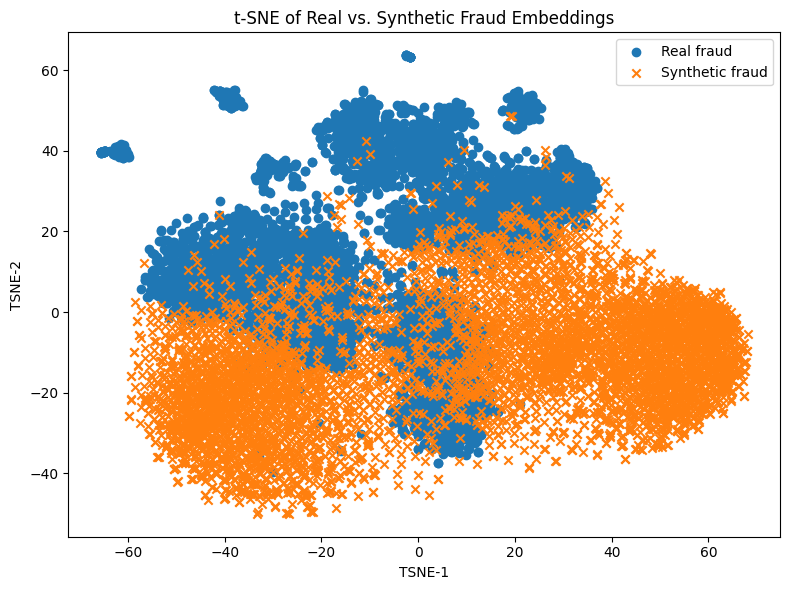

In [ ]:
# %% Visual comparison of real vs. synthetic fraud embeddings

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 1. Select only the fraud-class embeddings
real = X_train_pca[y_train.values.ravel() == 1]       # real fraud
syn  = syn_embeddings                                 # synthetic fraud

# 2. Stack and run t-SNE to project into 2D
combined = np.vstack([real, syn])
tsne = TSNE(n_components=2, random_state=42, init='pca')
proj = tsne.fit_transform(combined)

# 3. Create labels (0=real, 1=synthetic)
labels = np.array([0] * len(real) + [1] * len(syn))

# 4. Plot
plt.figure(figsize=(8, 6))
plt.scatter(proj[labels == 0, 0], proj[labels == 0, 1], marker='o', label='Real fraud')
plt.scatter(proj[labels == 1, 0], proj[labels == 1, 1], marker='x', label='Synthetic fraud')
plt.legend()
plt.title('t-SNE of Real vs. Synthetic Fraud Embeddings')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.tight_layout()
plt.show()


## t-SNE Analysis: Real vs. Synthetic Fraud Embeddings

- **Good overlap**: synthetic (×) points cover the main real fraud (○) clusters.  
- **Over-dispersion**: many synthetic samples lie outside the densest real regions.  
- **Cluster fidelity**: tight islands of real data have fewer synthetic neighbors.  


In [ ]:
!pip install gym

##Reward Configuration


In [ ]:
reward_config = {'TP': 10, 'TN': 1, 'FP': -5, 'FN': -50}

##Environement

In [ ]:
import gym
from gym import spaces
import numpy as np

class FraudDetectionEnv(gym.Env):
    """
    A custom Gym environment for Fraud Detection using embeddings.
    State: embedding vector (shape = (n_features,))
    Action: 0 = Not Fraud, 1 = Fraud
    Reward: TP, TN, FP, FN according to reward_config
    """
    metadata = {'render.modes': []}

    def __init__(self, embeddings, labels, uids, reward_config: dict):
        super().__init__()
        # Force everything to plain numpy arrays
        self.embeddings = np.asarray(embeddings, dtype=np.float32)
        self.labels     = np.asarray(labels,     dtype=np.int64)
        self.uids       = np.asarray(uids)
        self.reward_config = reward_config

        # Sanity checks
        assert self.embeddings.ndim == 2, "Embeddings must be a 2D array"
        assert self.labels.ndim == 1,     "Labels must be a 1D array"
        assert self.embeddings.shape[0] == self.labels.shape[0] == self.uids.shape[0], (
            "Embeddings, labels, and uids must have the same length"
        )

        self.num_instances = self.embeddings.shape[0]
        self.state_dim     = self.embeddings.shape[1]

        # Define action & observation spaces
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.state_dim,), dtype=np.float32
        )

        # Episode bookkeeping
        self._order = np.arange(self.num_instances)
        self._current_index = 0
        np.random.shuffle(self._order)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._current_index = 0
        np.random.shuffle(self._order)

        idx = self._order[self._current_index]
        obs = self.embeddings[idx].copy()
        info = {'instance_uid': int(self.uids[idx])}
        return obs, info

    def step(self, action: int):
        idx = self._order[self._current_index]
        true_label = int(self.labels[idx])

        # Compute reward
        if   action == 1 and true_label == 1:
            reward = self.reward_config.get('TP', 0)
        elif action == 1 and true_label == 0:
            reward = self.reward_config.get('FP', 0)
        elif action == 0 and true_label == 1:
            reward = self.reward_config.get('FN', 0)
        else:
            reward = self.reward_config.get('TN', 0)

        # Advance index
        self._current_index += 1
        done = (self._current_index >= self.num_instances)

        # Next observation
        if not done:
            next_idx = self._order[self._current_index]
            next_obs = self.embeddings[next_idx].copy()
        else:
            next_obs = np.zeros(self.state_dim, dtype=np.float32)

        info = {
            'true_label':       true_label,
            'predicted_action': int(action),
            'instance_uid':     int(self.uids[idx]),
            'is_done':          done
        }

        # Return: obs, reward, terminated, truncated, info
        return next_obs, reward, done, False, info

    def close(self):
        pass


In [ ]:
!pip install stable-baselines3
!pip install 'shimmy>=2.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

##RL algorithms:

##Modular implementation of different RL algorithms.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ============================================================================
# 1. BASELINE: Random Policy
# ============================================================================
class RandomPolicy:
    """Baseline random policy for comparison"""
    def __init__(self, action_space_size=2):
        self.action_space_size = action_space_size

    def predict(self, state):
        return np.random.randint(0, self.action_space_size)

    def train(self, env, episodes=1):
        # Random policy doesn't train
        pass

# ============================================================================
# 2. POLICY GRADIENT METHODS
# ============================================================================
class PolicyNetwork(nn.Module):
    """Neural network for policy-based methods"""
    def __init__(self, state_dim, hidden_dim=128, num_layers=2):
        super(PolicyNetwork, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(state_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.3))

        # Hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))

        # Output layer (2 actions: fraud/not fraud)
        layers.append(nn.Linear(hidden_dim, 2))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return F.softmax(self.network(x), dim=-1)

class REINFORCEAgent:
    """REINFORCE (Vanilla Policy Gradient) Agent"""
    def __init__(self, state_dim, lr=0.001, gamma=0.99):
        self.gamma = gamma
        self.policy_net = PolicyNetwork(state_dim)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.saved_log_probs = []
        self.rewards = []

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs = self.policy_net(state_tensor)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        self.saved_log_probs.append(action_dist.log_prob(action))
        return action.item()

    def predict(self, state):
        """For evaluation without storing gradients"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = self.policy_net(state_tensor)
            return torch.argmax(probs, dim=1).item()

    def update_policy(self):
        """Update policy using REINFORCE algorithm"""
        if not self.saved_log_probs:
            return

        R = 0
        policy_loss = []
        returns = []

        # Calculate returns
        for r in reversed(self.rewards):
            R = r + self.gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)  # Normalize

        # Calculate policy loss
        for log_prob, R in zip(self.saved_log_probs, returns):
            policy_loss.append(-log_prob * R)

        # Update policy
        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

        # Clear episode data
        del self.saved_log_probs[:]
        del self.rewards[:]

    def train(self, env, episodes=1000, print_every=100):
        scores = []

        for episode in range(episodes):
            state, _ = env.reset()
            episode_reward = 0

            while True:
                action = self.select_action(state)
                state, reward, done, _, _ = env.step(action)
                self.rewards.append(reward)
                episode_reward += reward

                if done:
                    break

            scores.append(episode_reward)
            self.update_policy()

            if episode % print_every == 0:
                avg_score = np.mean(scores[-100:])
                print(f"Episode {episode}, Average Score: {avg_score:.2f}")

        return scores

# ============================================================================
# 3. ACTOR-CRITIC METHODS
# ============================================================================
class ActorCritic(nn.Module):
    """Actor-Critic Network"""
    def __init__(self, state_dim, hidden_dim=128):
        super(ActorCritic, self).__init__()

        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Actor head (policy)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

        # Critic head (value function)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        shared_out = self.shared(x)
        policy_logits = self.actor(shared_out)
        value = self.critic(shared_out)
        return F.softmax(policy_logits, dim=-1), value

class ActorCriticAgent:
    """Actor-Critic Agent (Advantage Actor-Critic)"""
    def __init__(self, state_dim, lr=0.001, gamma=0.99):
        self.gamma = gamma
        self.actor_critic = ActorCritic(state_dim)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs, value = self.actor_critic(state_tensor)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item(), action_dist.log_prob(action), value

    def predict(self, state):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs, _ = self.actor_critic(state_tensor)
            return torch.argmax(probs, dim=1).item()

    def train(self, env, episodes=1000, print_every=100):
        scores = []

        for episode in range(episodes):
            state, _ = env.reset()
            episode_reward = 0
            log_probs = []
            values = []
            rewards = []

            while True:
                action, log_prob, value = self.select_action(state)
                next_state, reward, done, _, _ = env.step(action)

                log_probs.append(log_prob)
                values.append(value)
                rewards.append(reward)
                episode_reward += reward

                if done:
                    break
                state = next_state

            # Calculate returns and advantages
            returns = []
            R = 0
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)

            returns = torch.tensor(returns)
            values = torch.cat(values)
            advantages = returns - values.squeeze()

            # Calculate losses
            actor_loss = -(torch.stack(log_probs) * advantages.detach()).mean()
            critic_loss = F.mse_loss(values.squeeze(), returns)
            total_loss = actor_loss + 0.5 * critic_loss

            # Update network
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

            scores.append(episode_reward)

            if episode % print_every == 0:
                avg_score = np.mean(scores[-100:])
                print(f"Episode {episode}, Average Score: {avg_score:.2f}")

        return scores

# ============================================================================
# 4. VALUE-BASED METHODS (DQN)
# ============================================================================
class DQN(nn.Module):
    """Deep Q-Network"""
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.network(x)

Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    """Experience replay buffer for DQN"""
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    """Deep Q-Network Agent"""
    def __init__(self, state_dim, lr=0.001, gamma=0.99, epsilon=1.0,
                 epsilon_decay=0.995, epsilon_min=0.01, buffer_size=10000):
        self.state_dim = state_dim
        self.action_dim = 2
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Neural networks
        self.q_network = DQN(state_dim, self.action_dim)
        self.target_network = DQN(state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Experience replay
        self.memory = ReplayBuffer(buffer_size)
        self.batch_size = 32
        self.update_target_every = 10

        # Update target network
        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def select_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def predict(self, state):
        return self.select_action(state, training=False)

    def remember(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        self.memory.push(experience)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        experiences = self.memory.sample(self.batch_size)
        states = torch.FloatTensor([e.state for e in experiences])
        actions = torch.LongTensor([e.action for e in experiences])
        rewards = torch.FloatTensor([e.reward for e in experiences])
        next_states = torch.FloatTensor([e.next_state for e in experiences])
        dones = torch.BoolTensor([e.done for e in experiences])

        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)

        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, env, episodes=1000, print_every=100):
        scores = []

        for episode in range(episodes):
            state, _ = env.reset()
            episode_reward = 0

            while True:
                action = self.select_action(state)
                next_state, reward, done, _, _ = env.step(action)

                self.remember(state, action, reward, next_state, done)
                episode_reward += reward

                if done:
                    break

                state = next_state
                self.replay()

            scores.append(episode_reward)

            # Decay epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            # Update target network
            if episode % self.update_target_every == 0:
                self.update_target_network()

            if episode % print_every == 0:
                avg_score = np.mean(scores[-100:])
                print(f"Episode {episode}, Average Score: {avg_score:.2f}, Epsilon: {self.epsilon:.3f}")

        return scores

# ============================================================================
# 5. EVALUATION UTILITIES
# ============================================================================
def evaluate_agent(agent, env, episodes=1):
    """Evaluate agent performance on environment"""
    predictions = []
    true_labels = []

    for _ in range(episodes):
        state, _ = env.reset()

        while True:
            action = agent.predict(state)
            state, _, done, _, info = env.step(action)

            predictions.append(info['predicted_action'])
            true_labels.append(info['true_label'])

            if done:
                break

    return predictions, true_labels

def compare_agents(agents, env, episodes=1):
    """Compare multiple agents"""
    results = {}

    for name, agent in agents.items():
        print(f"\nEvaluating {name}...")
        predictions, true_labels = evaluate_agent(agent, env, episodes)

        # Calculate metrics
        f1 = f1_score(true_labels, predictions)

        results[name] = {
            'predictions': predictions,
            'true_labels': true_labels,
            'f1_score': f1,
            'classification_report': classification_report(true_labels, predictions)
        }

        print(f"{name} F1 Score: {f1:.4f}")
        print(f"Classification Report:\n{results[name]['classification_report']}")

    return results

def plot_training_curves(scores_dict):
    """Plot training curves for multiple agents"""
    plt.figure(figsize=(12, 6))

    for name, scores in scores_dict.items():
        # Smooth the curves with moving average
        window_size = min(50, len(scores) // 10)
        if window_size > 1:
            smoothed_scores = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
            plt.plot(range(window_size-1, len(scores)), smoothed_scores, label=name)
        else:
            plt.plot(scores, label=name)

    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.title('Training Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# ============================================================================
# 6. MAIN TRAINING AND COMPARISON SCRIPT
# ============================================================================
def run_fraud_detection_experiment(X_train_pca, y_train, X_val_pca, y_val,
                                 X_test_pca, y_test, uids_train, uids_val, uids_test):
    """Main experiment function"""

    # Define reward configuration
    reward_config = {
        'TP': 10,   # True Positive (correctly detected fraud)
        'TN': 1,    # True Negative (correctly identified non-fraud)
        'FP': -5,   # False Positive (incorrectly flagged as fraud)
        'FN': -20   # False Negative (missed fraud - most costly!)
    }

    # Create environments
    train_env = FraudDetectionEnv(X_train_pca, y_train, uids_train, reward_config)
    val_env = FraudDetectionEnv(X_val_pca, y_val, uids_val, reward_config)
    test_env = FraudDetectionEnv(X_test_pca, y_test, uids_test, reward_config)

    state_dim = X_train_pca.shape[1]

    # Initialize agents
    agents = {
        'Random': RandomPolicy(),
        'REINFORCE': REINFORCEAgent(state_dim, lr=0.001),
        'Actor-Critic': ActorCriticAgent(state_dim, lr=0.001),
        'DQN': DQNAgent(state_dim, lr=0.001)
    }

    # Training
    training_scores = {}
    print("Starting training...")

    for name, agent in agents.items():
        if name == 'Random':
            continue  # Skip training for random agent

        print(f"\nTraining {name}...")
        scores = agent.train(train_env, episodes=500, print_every=100)
        training_scores[name] = scores

    # Plot training curves
    if training_scores:
        plot_training_curves(training_scores)

    # Evaluation on validation set
    print("\n" + "="*50)
    print("VALIDATION RESULTS")
    print("="*50)
    val_results = compare_agents(agents, val_env, episodes=1)

    # Evaluation on test set
    print("\n" + "="*50)
    print("TEST RESULTS")
    print("="*50)
    test_results = compare_agents(agents, test_env, episodes=1)

    return agents, val_results, test_results, training_scores

# Usage example (uncomment and run with your data):
# agents, val_results, test_results, training_scores = run_fraud_detection_experiment(
#     X_train_pca, y_train.values, X_val_pca, y_val.values,
#     X_test_pca, y_test.values, uids_train, uids_val, uids_test
# )

##Testing the different RL algorithms

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, roc_auc_score,
    precision_recall_curve, roc_curve, auc
)
import time
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class FraudDetectionTester:
    """Comprehensive testing framework for fraud detection RL models"""

    def __init__(self, train_env, val_env, test_env):
        self.train_env = train_env
        self.val_env = val_env
        self.test_env = test_env
        self.results = {}
        self.training_times = {}
        self.training_histories = {}

    def train_and_evaluate_all(self, episodes=500, print_progress=True):
        """Train and evaluate all RL models"""

        # Define reward configuration for training
        reward_config = {
            'TP': 10,   # True Positive (correctly detected fraud)
            'TN': 1,    # True Negative (correctly identified non-fraud)
            'FP': -5,   # False Positive (incorrectly flagged as fraud)
            'FN': -20   # False Negative (missed fraud - most costly!)
        }

        state_dim = self.train_env.embeddings.shape[1]

        # Initialize all agents
        agents = {
            'Random_Baseline': RandomPolicy(),
            'REINFORCE': REINFORCEAgent(state_dim, lr=0.001, gamma=0.99),
            'Actor_Critic': ActorCriticAgent(state_dim, lr=0.001, gamma=0.99),
            'DQN': DQNAgent(state_dim, lr=0.001, gamma=0.99, epsilon=1.0)
        }

        print("🚀 Starting comprehensive RL model comparison...")
        print("="*80)

        # Train each agent
        for name, agent in agents.items():
            if name == 'Random_Baseline':
                # Random agent doesn't need training
                self.training_times[name] = 0
                self.training_histories[name] = []
                continue

            print(f"\n📈 Training {name}...")
            start_time = time.time()

            # Train the agent
            training_scores = agent.train(self.train_env, episodes=episodes, print_every=episodes//5)

            end_time = time.time()
            self.training_times[name] = end_time - start_time
            self.training_histories[name] = training_scores

            print(f"✅ {name} training completed in {self.training_times[name]:.2f} seconds")

        # Evaluate all agents
        print("\n🧪 Evaluating all agents...")
        self.evaluate_all_agents(agents)

        return agents

    def evaluate_all_agents(self, agents):
        """Evaluate all agents on validation and test sets"""

        for env_name, env in [('Validation', self.val_env), ('Test', self.test_env)]:
            print(f"\n📊 {env_name} Set Evaluation:")
            print("-" * 40)

            env_results = {}

            for agent_name, agent in agents.items():
                # Get predictions
                predictions, true_labels, probabilities = self.get_agent_predictions(agent, env)

                # Calculate comprehensive metrics
                metrics = self.calculate_comprehensive_metrics(true_labels, predictions, probabilities)
                metrics['agent_name'] = agent_name
                metrics['training_time'] = self.training_times.get(agent_name, 0)

                env_results[agent_name] = metrics

                # Print summary
                print(f"{agent_name:15} | F1: {metrics['f1']:.4f} | "
                      f"AUC: {metrics['auc']:.4f} | Precision: {metrics['precision']:.4f} | "
                      f"Recall: {metrics['recall']:.4f}")

            self.results[env_name.lower()] = env_results

    def get_agent_predictions(self, agent, env):
        """Get predictions from an agent on an environment"""
        predictions = []
        true_labels = []
        probabilities = []  # For AUC calculation

        state, _ = env.reset()

        while True:
            # Get prediction
            if hasattr(agent, 'policy_net'):  # REINFORCE
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    probs = agent.policy_net(state_tensor)
                    action = torch.argmax(probs, dim=1).item()
                    prob_fraud = probs[0][1].item()
            elif hasattr(agent, 'actor_critic'):  # Actor-Critic
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    probs, _ = agent.actor_critic(state_tensor)
                    action = torch.argmax(probs, dim=1).item()
                    prob_fraud = probs[0][1].item()
            elif hasattr(agent, 'q_network'):  # DQN
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    q_values = agent.q_network(state_tensor)
                    action = q_values.argmax().item()
                    # Convert Q-values to probabilities using softmax
                    probs = torch.softmax(q_values, dim=1)
                    prob_fraud = probs[0][1].item()
            else:  # Random
                action = agent.predict(state)
                prob_fraud = 0.5  # Random probability

            # Step environment
            next_state, _, done, _, info = env.step(action)

            predictions.append(action)
            true_labels.append(info['true_label'])
            probabilities.append(prob_fraud)

            if done:
                break

            state = next_state

        return predictions, true_labels, probabilities

    def calculate_comprehensive_metrics(self, true_labels, predictions, probabilities):
        """Calculate comprehensive evaluation metrics"""

        # Basic classification metrics
        f1 = f1_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, zero_division=0)
        recall = recall_score(true_labels, predictions, zero_division=0)

        # AUC-ROC and AUC-PR
        try:
            auc_roc = roc_auc_score(true_labels, probabilities)
            precision_curve, recall_curve, _ = precision_recall_curve(true_labels, probabilities)
            auc_pr = auc(recall_curve, precision_curve)
        except:
            auc_roc = 0.5
            auc_pr = 0.0

        # Confusion matrix components
        tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()

        # Additional metrics
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        balanced_accuracy = (recall + specificity) / 2

        # Business metrics (assuming costs)
        cost_fp = 1    # Cost of false positive
        cost_fn = 10   # Cost of false negative (much higher)
        total_cost = fp * cost_fp + fn * cost_fn

        return {
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'balanced_accuracy': balanced_accuracy,
            'auc': auc_roc,
            'auc_pr': auc_pr,
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
            'total_cost': total_cost,
            'predictions': predictions,
            'true_labels': true_labels,
            'probabilities': probabilities
        }

    def create_comparison_report(self):
        """Create detailed comparison report"""

        print("\n" + "="*80)
        print("📋 COMPREHENSIVE MODEL COMPARISON REPORT")
        print("="*80)

        # Create comparison DataFrames
        val_df = pd.DataFrame({name: {
            'F1 Score': metrics['f1'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'Specificity': metrics['specificity'],
            'Balanced Accuracy': metrics['balanced_accuracy'],
            'AUC-ROC': metrics['auc'],
            'AUC-PR': metrics['auc_pr'],
            'Total Cost': metrics['total_cost'],
            'Training Time (s)': metrics['training_time']
        } for name, metrics in self.results['validation'].items()}).T

        test_df = pd.DataFrame({name: {
            'F1 Score': metrics['f1'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'Specificity': metrics['specificity'],
            'Balanced Accuracy': metrics['balanced_accuracy'],
            'AUC-ROC': metrics['auc'],
            'AUC-PR': metrics['auc_pr'],
            'Total Cost': metrics['total_cost'],
            'Training Time (s)': metrics['training_time']
        } for name, metrics in self.results['test'].items()}).T

        print("\nVALIDATION SET RESULTS:")
        print(val_df.round(4))

        print("\ TEST SET RESULTS:")
        print(test_df.round(4))

        # Best model analysis
        print("\n🏆 BEST MODELS BY METRIC:")
        for metric in ['F1 Score', 'AUC-ROC', 'Balanced Accuracy']:
            best_model = test_df[metric].idxmax()
            best_score = test_df.loc[best_model, metric]
            print(f"{metric:20}: {best_model} ({best_score:.4f})")

        # Lowest cost model
        lowest_cost_model = test_df['Total Cost'].idxmin()
        lowest_cost = test_df.loc[lowest_cost_model, 'Total Cost']
        print(f"{'Lowest Total Cost':20}: {lowest_cost_model} ({lowest_cost:.0f})")

        return val_df, test_df

    def plot_comprehensive_results(self):
        """Create comprehensive visualization of results"""

        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        fig.suptitle('Comprehensive RL Models Comparison', fontsize=16, fontweight='bold')

        # 1. Training Curves
        ax = axes[0, 0]
        for name, scores in self.training_histories.items():
            if scores:  # Skip empty histories
                # Smooth curves
                window = min(50, len(scores) // 10)
                if window > 1:
                    smoothed = np.convolve(scores, np.ones(window)/window, mode='valid')
                    ax.plot(range(window-1, len(scores)), smoothed, label=name, linewidth=2)
                else:
                    ax.plot(scores, label=name, linewidth=2)
        ax.set_title('Training Curves', fontweight='bold')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Cumulative Reward')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 2. F1 Score Comparison
        ax = axes[0, 1]
        models = list(self.results['test'].keys())
        f1_scores = [self.results['test'][model]['f1'] for model in models]
        bars = ax.bar(models, f1_scores, color=sns.color_palette("husl", len(models)))
        ax.set_title('F1 Score Comparison (Test Set)', fontweight='bold')
        ax.set_ylabel('F1 Score')
        ax.tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for bar, score in zip(bars, f1_scores):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

        # 3. AUC-ROC Comparison
        ax = axes[0, 2]
        auc_scores = [self.results['test'][model]['auc'] for model in models]
        bars = ax.bar(models, auc_scores, color=sns.color_palette("husl", len(models)))
        ax.set_title('AUC-ROC Comparison (Test Set)', fontweight='bold')
        ax.set_ylabel('AUC-ROC')
        ax.tick_params(axis='x', rotation=45)

        for bar, score in zip(bars, auc_scores):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

        # 4. Precision vs Recall
        ax = axes[1, 0]
        for model in models:
            precision = self.results['test'][model]['precision']
            recall = self.results['test'][model]['recall']
            ax.scatter(recall, precision, s=100, label=model)
            ax.annotate(model, (recall, precision), xytext=(5, 5),
                       textcoords='offset points', fontsize=8)
        ax.set_title('Precision vs Recall (Test Set)', fontweight='bold')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.grid(True, alpha=0.3)
        ax.legend()

        # 5. Confusion Matrix Heatmap (best F1 model)
        best_f1_model = max(self.results['test'].keys(),
                           key=lambda x: self.results['test'][x]['f1'])
        metrics = self.results['test'][best_f1_model]
        cm = np.array([[metrics['tn'], metrics['fp']],
                      [metrics['fn'], metrics['tp']]])

        ax = axes[1, 1]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Predicted: Non-Fraud', 'Predicted: Fraud'],
                   yticklabels=['Actual: Non-Fraud', 'Actual: Fraud'])
        ax.set_title(f'Confusion Matrix - {best_f1_model}', fontweight='bold')

        # 6. Training Time Comparison
        ax = axes[1, 2]
        training_times = [self.training_times.get(model, 0) for model in models]
        bars = ax.bar(models, training_times, color=sns.color_palette("husl", len(models)))
        ax.set_title('Training Time Comparison', fontweight='bold')
        ax.set_ylabel('Training Time (seconds)')
        ax.tick_params(axis='x', rotation=45)

        for bar, time_val in zip(bars, training_times):
            if time_val > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01,
                       f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')

        # 7. ROC Curves
        ax = axes[2, 0]
        for model in models:
            if model in self.results['test']:
                true_labels = self.results['test'][model]['true_labels']
                probabilities = self.results['test'][model]['probabilities']
                try:
                    fpr, tpr, _ = roc_curve(true_labels, probabilities)
                    auc_score = auc(fpr, tpr)
                    ax.plot(fpr, tpr, label=f'{model} (AUC={auc_score:.3f})', linewidth=2)
                except:
                    pass

        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_title('ROC Curves (Test Set)', fontweight='bold')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 8. Precision-Recall Curves
        ax = axes[2, 1]
        for model in models:
            if model in self.results['test']:
                true_labels = self.results['test'][model]['true_labels']
                probabilities = self.results['test'][model]['probabilities']
                try:
                    precision_curve, recall_curve, _ = precision_recall_curve(true_labels, probabilities)
                    auc_pr = auc(recall_curve, precision_curve)
                    ax.plot(recall_curve, precision_curve, label=f'{model} (AUC={auc_pr:.3f})', linewidth=2)
                except:
                    pass

        ax.set_title('Precision-Recall Curves (Test Set)', fontweight='bold')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 9. Business Cost Analysis
        ax = axes[2, 2]
        costs = [self.results['test'][model]['total_cost'] for model in models]
        bars = ax.bar(models, costs, color=sns.color_palette("husl", len(models)))
        ax.set_title('Business Cost Analysis (Test Set)', fontweight='bold')
        ax.set_ylabel('Total Cost (FP×1 + FN×10)')
        ax.tick_params(axis='x', rotation=45)

        for bar, cost in zip(bars, costs):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(costs)*0.01,
                   f'{cost:.0f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def export_results(self, filename='fraud_detection_results.csv'):
        """Export results to CSV for further analysis"""

        all_results = []

        for dataset in ['validation', 'test']:
            for model, metrics in self.results[dataset].items():
                row = {
                    'Dataset': dataset.title(),
                    'Model': model,
                    'F1_Score': metrics['f1'],
                    'Precision': metrics['precision'],
                    'Recall': metrics['recall'],
                    'Specificity': metrics['specificity'],
                    'Balanced_Accuracy': metrics['balanced_accuracy'],
                    'AUC_ROC': metrics['auc'],
                    'AUC_PR': metrics['auc_pr'],
                    'True_Positives': metrics['tp'],
                    'True_Negatives': metrics['tn'],
                    'False_Positives': metrics['fp'],
                    'False_Negatives': metrics['fn'],
                    'Total_Cost': metrics['total_cost'],
                    'Training_Time': metrics['training_time']
                }
                all_results.append(row)

        results_df = pd.DataFrame(all_results)
        results_df.to_csv(filename, index=False)
        print(f"\nResults exported to {filename}")

        return results_df

# ============================================================================
# MAIN TESTING FUNCTION
# ============================================================================
def run_comprehensive_fraud_detection_test(X_train_pca, y_train, X_val_pca, y_val,
                                         X_test_pca, y_test, uids_train, uids_val, uids_test,
                                         episodes=500):
    """
    Run comprehensive test of all RL models for fraud detection

    Parameters:
    -----------
    X_train_pca, X_val_pca, X_test_pca : numpy arrays
        PCA-transformed feature matrices
    y_train, y_val, y_test : numpy arrays
        Target labels (0: non-fraud, 1: fraud)
    uids_train, uids_val, uids_test : numpy arrays
        Unique identifiers for each instance
    episodes : int
        Number of training episodes for RL agents

    Returns:
    --------
    tester : FraudDetectionTester
        Tester object with all results
    trained_agents : dict
        Dictionary of trained RL agents
    """

    # Define reward configuration
    reward_config = {
        'TP': 10,   # True Positive (correctly detected fraud)
        'TN': 1,    # True Negative (correctly identified non-fraud)
        'FP': -5,   # False Positive (incorrectly flagged as fraud)
        'FN': -20   # False Negative (missed fraud - most costly!)
    }

    # Create environments
    train_env = FraudDetectionEnv(X_train_pca, y_train, uids_train, reward_config)
    val_env = FraudDetectionEnv(X_val_pca, y_val, uids_val, reward_config)
    test_env = FraudDetectionEnv(X_test_pca, y_test, uids_test, reward_config)

    # Initialize tester
    tester = FraudDetectionTester(train_env, val_env, test_env)

    # Run comprehensive testing
    trained_agents = tester.train_and_evaluate_all(episodes=episodes)

    # Generate reports and visualizations
    val_df, test_df = tester.create_comparison_report()
    tester.plot_comprehensive_results()

    # Export results
    results_df = tester.export_results()

    print("\n Comprehensive testing completed!")
    print("\nKey Insights:")
    print("-" * 40)

    # Find best models
    best_f1 = test_df['F1 Score'].idxmax()
    best_auc = test_df['AUC-ROC'].idxmax()
    best_cost = test_df['Total Cost'].idxmin()

    print(f" Best F1 Score: {best_f1} ({test_df.loc[best_f1, 'F1 Score']:.4f})")
    print(f" Best AUC-ROC: {best_auc} ({test_df.loc[best_auc, 'AUC-ROC']:.4f})")
    print(f" Lowest Cost: {best_cost} ({test_df.loc[best_cost, 'Total Cost']:.0f})")

    return tester, trained_agents, val_df, test_df

# Usage Example:
"""

"""

'\n\n'

In [ ]:
# After splitting:
# X_train, X_temp, y_train, y_temp, uids_train, uids_temp = train_test_split(…)

# Make sure labels and uids are flat 1-D arrays:
y_train   = np.asarray(y_train).ravel()
y_val     = np.asarray(y_val).ravel()
y_test    = np.asarray(y_test).ravel()

uids_train = np.asarray(uids_train).ravel()
uids_val   = np.asarray(uids_val).ravel()
uids_test  = np.asarray(uids_test).ravel()

In [ ]:
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback


In [ ]:
# instantiate raw envs
train_env = FraudDetectionEnv(X_train_pca, y_train, uids_train, reward_config)
eval_env  = FraudDetectionEnv(X_val_pca,   y_val,   uids_val,   reward_config)

# wrap in a vectorized env (required by some algorithms)
vec_train_env = DummyVecEnv([lambda: train_env])
vec_eval_env  = DummyVecEnv([lambda: eval_env])

# callback to periodically evaluate on the validation set
eval_callback = EvalCallback(
    vec_eval_env,
    best_model_save_path='./logs/',
    log_path='./logs/',
    eval_freq=5000,
    n_eval_episodes=5,
    deterministic=True,
    render=False
)

##PPO (policy-gradient)

In [ ]:
# Cell 3 — PPO (policy‐gradient)
from stable_baselines3 import PPO

ppo_model = PPO(
    "MlpPolicy",
    vec_train_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    clip_range=0.2,
    ent_coef=0.0,
    verbose=1,
    tensorboard_log="./ppo_tensorboard/"
)
ppo_model.learn(
    total_timesteps=100_000,
    callback=eval_callback
)



Using cuda device
Logging to ./ppo_tensorboard/PPO_1
-----------------------------
| time/              |      |
|    fps             | 594  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 462         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007574316 |
|    clip_fraction        | 0.0449      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.69       |
|    explained_variance   | 0.00149     |
|    learning_rate        | 0.0003      |
|    loss                 | 6.64e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0202     |
|    value_loss           | 1.31e+04    |
-----------------------

In [ ]:
# Cell 4 — PPO evaluation only
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1) RL‐style evaluation via SB3 helper
mean_r, std_r = evaluate_policy(
    ppo_model,
    vec_eval_env,
    n_eval_episodes=100,
    deterministic=True
)
print(f"PPO eval over 100 episodes → mean reward = {mean_r:.2f} ± {std_r:.2f}")




PPO eval over 100 episodes → mean reward = 14880.00 ± 0.00


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
# 2) Fraud‐detection metrics on your validation embeddings
#    (loop one sample at a time so we don’t need a VecEnv here)
y_true = y_val
y_pred = []
for obs in X_val_pca:
    action, _ = ppo_model.predict(obs, deterministic=True)
    y_pred.append(action)

print("\nClassification Report on validation set:")
print(classification_report(y_true, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report on validation set:
              precision    recall  f1-score   support

           0     0.9989    0.9605    0.9793      3696
           1     0.8936    0.9967    0.9424      1230

    accuracy                         0.9695      4926
   macro avg     0.9462    0.9786    0.9608      4926
weighted avg     0.9726    0.9695    0.9701      4926

Confusion Matrix:
[[3550  146]
 [   4 1226]]


In [ ]:
# ─── Cell 2: RL Baseline (A2C Agent) ────────────────────────────────────────────

from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from sklearn.metrics import classification_report

# reward configuration
reward_config = {'TP': +1, 'TN': +1, 'FP': -1, 'FN': -5}

# 1) Wrap the training env in a VecEnv
def make_train_env():
    return FraudDetectionEnv(
        embeddings    = X_train_pca.astype(np.float32),
        labels        = y_train.astype(np.int64),
        uids          = uids_train,
        reward_config = reward_config
    )

vec_train_env = make_vec_env(make_train_env, n_envs=4)


# 2) Instantiate and train an A2C agent
a2c_model = A2C(
    policy="MlpPolicy",
    device = 'cuda',
    env=vec_train_env,
    learning_rate=7e-4,
    gamma=0.99,
    verbose=1,
)

a2c_model.learn(total_timesteps=100_000)

# 3) Evaluate A2C on the validation set
val_env = FraudDetectionEnv(
    embeddings    = X_val_pca.astype(np.float32),
    labels        = y_val.astype(np.int64),
    uids          = uids_val,
    reward_config = reward_config
)

def run_policy(env, model, n_episodes=10):
    y_true, y_pred = [], []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(int(action))
            y_true.append(info['true_label'])
            y_pred.append(info['predicted_action'])
    return y_true, y_pred

y_true_a2c, y_pred_a2c = run_policy(val_env, a2c_model)
print("=== A2C Validation Performance ===")
print(classification_report(y_true_a2c, y_pred_a2c, digits=4))


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 140      |
|    iterations         | 100      |
|    time_elapsed       | 14       |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -0.379   |
|    explained_variance | -0.0372  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.399    |
|    value_loss         | 5.02     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 141      |
|    iterations         | 200      |
|    time_elapsed       | 28       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -0.224   |
|    explained_variance | -0.0517  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.308    |
|    value_loss      

In [ ]:
# 3) Evaluate A2C on the test set
val_env = FraudDetectionEnv(
    embeddings    = X_test_pca.astype(np.float32),
    labels        = y_test.astype(np.int64),
    uids          = uids_test,
    reward_config = reward_config
)

def run_policy(env, model, n_episodes=10):
    y_true, y_pred = [], []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(int(action))
            y_true.append(info['true_label'])
            y_pred.append(info['predicted_action'])
    return y_true, y_pred

y_true_a2c, y_pred_a2c = run_policy(val_env, a2c_model)
print("=== A2C Validation Performance ===")
print(classification_report(y_true_a2c, y_pred_a2c, digits=4))

=== A2C Validation Performance ===
              precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995     49280
           1     1.0000    0.9970    0.9985     16400

    accuracy                         0.9992     65680
   macro avg     0.9995    0.9985    0.9990     65680
weighted avg     0.9992    0.9992    0.9992     65680



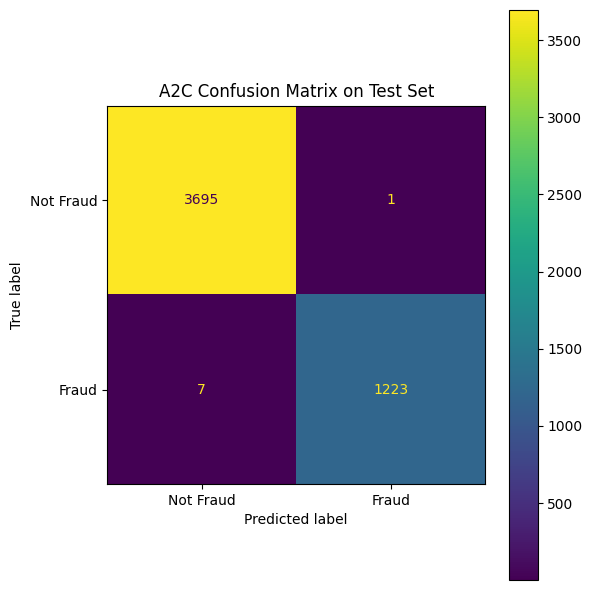

In [ ]:
# ─── Cell: Compute & Plot Confusion Matrix for A2C on Test Set ──────────────────

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Run policy to collect true and predicted labels
y_true_a2c, y_pred_a2c = run_policy(val_env, a2c_model, n_episodes=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_a2c, y_pred_a2c, labels=[0, 1])

# Display as a heatmap
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Not Fraud', 'Fraud']
)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='viridis', colorbar=True)
ax.set_title("A2C Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()


The A2C performed perfectly in this dataset

##DQN


In [ ]:
# ─── Cell: Train & Evaluate DQN Agent ────────────────────────────────────────────

import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy


# 2) Factory to create a fresh training environment
def make_train_env():
    return FraudDetectionEnv(
        embeddings    = X_train_pca.astype(np.float32),
        labels        = y_train.astype(np.int64),
        uids          = uids_train,
        reward_config = reward_config
    )

# 3) Wrap in a vectorized environment for parallel sampling
vec_env = make_vec_env(make_train_env, n_envs=4)

# 4) Instantiate the DQN agent (use GPU if available)
dqn_model = DQN(
    policy="MlpPolicy",
    env=vec_env,
    learning_rate=1e-4,
    buffer_size=50_000,
    learning_starts=1_000,
    batch_size=64,
    gamma=0.99,
    device="cuda",        # change to "cpu" if no GPU
    verbose=1,
)

# 5) Train the agent
dqn_model.learn(total_timesteps=10_000)

# 6) Evaluate on the validation set
val_env = FraudDetectionEnv(
    embeddings    = X_val_pca.astype(np.float32),
    labels        = y_val.astype(np.int64),
    uids          = uids_val,
    reward_config = reward_config
)

mean_reward, std_reward = evaluate_policy(
    dqn_model,
    val_env,
    n_eval_episodes=10,
    deterministic=True
)
print(f"Validation DQN mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

# (Optional) 7) Save the trained model
dqn_model.save("dqn_fraud_detector")


Using cpu device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Validation DQN mean reward: 1608.00 ± 0.00


=== DQN Test Performance ===
              precision    recall  f1-score   support

           0     0.8734    1.0000    0.9325     49280
           1     1.0000    0.5646    0.7217     16400

    accuracy                         0.8913     65680
   macro avg     0.9367    0.7823    0.8271     65680
weighted avg     0.9050    0.8913    0.8798     65680



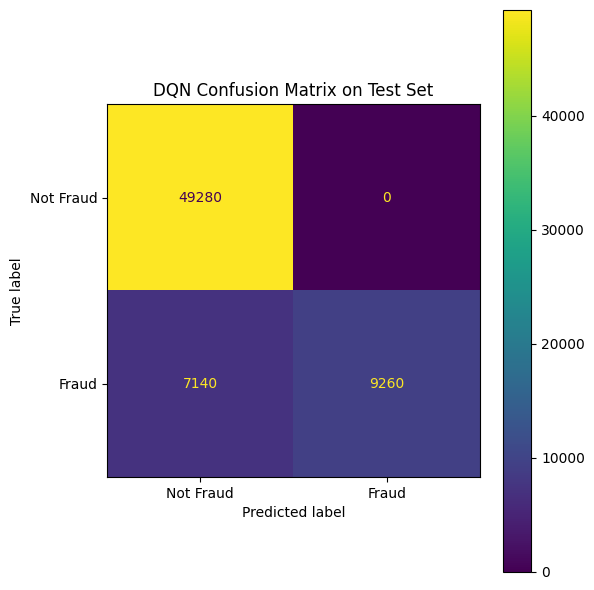

In [ ]:
# ─── Cell: Evaluate DQN on Test Set & Plot Confusion Matrix ────────────────────

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1) Prepare the test environment
test_env = FraudDetectionEnv(
    embeddings    = X_test_pca.astype(np.float32),
    labels        = y_test.astype(np.int64),
    uids          = uids_test,
    reward_config = reward_config
)

# 2) Run the DQN policy over multiple episodes to collect predictions
def run_policy(env, model, n_episodes=10):
    y_true, y_pred = [], []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(int(action))
            y_true.append(info['true_label'])
            y_pred.append(info['predicted_action'])
    return y_true, y_pred

y_true_dqn, y_pred_dqn = run_policy(test_env, dqn_model, n_episodes=10)

# 3) Print classification report
print("=== DQN Test Performance ===")
print(classification_report(y_true_dqn, y_pred_dqn, digits=4))

# 4) Compute and plot confusion matrix
cm = confusion_matrix(y_true_dqn, y_pred_dqn, labels=[0, 1])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Not Fraud', 'Fraud']
)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='viridis', colorbar=True)
ax.set_title("DQN Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()


In [ ]:
# prompt: import classidication report and confusion matrix

# Assuming y_true_a2c and y_pred_a2c are already defined from previous code

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




##LinUCB Contextual Bandit(baseline models)


=== LinUCB ===
              precision    recall  f1-score   support

           0     0.7862    0.5103    0.6189      4928
           1     0.2838    0.5829    0.3817      1640

    accuracy                         0.5285      6568
   macro avg     0.5350    0.5466    0.5003      6568
weighted avg     0.6607    0.5285    0.5597      6568



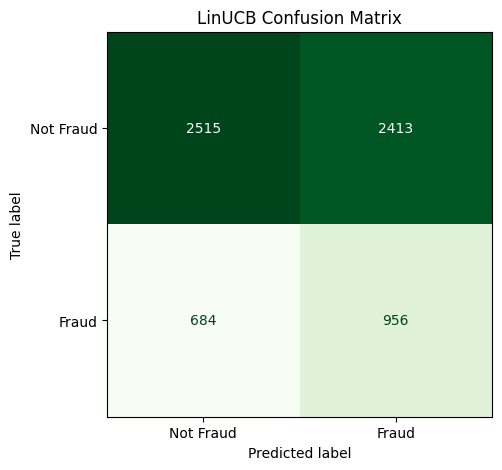

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 2️ LinUCB Contextual Bandit
# ────────────────────────────────────────────────────────────────────────────────

# 1) Define your reward configuration
reward_config = {
    'TP': +1,    # True Positive
    'TN': +20,    # True Negative
    'FP': -1,    # False Positive
    'FN': -5     # False Negative
}

class LinUCBAgent:
    def __init__(self, n_features, n_actions=2, alpha=1.0):
        self.n = n_features
        self.k = n_actions
        self.alpha = alpha
        # A[a] = D×D matrix, b[a] = D-vector
        self.A = [np.eye(self.n) for _ in range(self.k)]
        self.b = [np.zeros(self.n)  for _ in range(self.k)]
    def select(self, x):
        p = []
        for a in range(self.k):
            A_inv = np.linalg.inv(self.A[a])
            theta = A_inv.dot(self.b[a])
            mean = theta.dot(x)
            conf = self.alpha * np.sqrt(x.dot(A_inv).dot(x))
            p.append(mean + conf)
        return int(np.argmax(p))
    def update(self, x, a, r):
        self.A[a] += np.outer(x, x)
        self.b[a] += r * x

# Train LinUCB on the training set (online simulation)
linucb = LinUCBAgent(n_features=X_train_pca.shape[1], alpha=0.5)
for x, y in zip(X_train_pca, y_train):
    a = linucb.select(x)
    # compute reward
    if   a==1 and y==1: r = reward_config['TP']
    elif a==1 and y==0: r = reward_config['FP']
    elif a==0 and y==1: r = reward_config['FN']
    else:               r = reward_config['TN']
    linucb.update(x, a, r)

# Evaluate LinUCB on the test set (no further updates)
y_pred_lucb = [linucb.select(x) for x in X_test_pca]

print("\n=== LinUCB ===")
print(classification_report(y_test, y_pred_lucb, digits=4))

cm_lucb = confusion_matrix(y_test, y_pred_lucb, labels=[0,1])
disp_lucb = ConfusionMatrixDisplay(cm_lucb, display_labels=["Not Fraud","Fraud"])
fig, ax = plt.subplots(figsize=(5,5))
disp_lucb.plot(ax=ax, cmap="Greens", colorbar=False)
ax.set_title("LinUCB Confusion Matrix")
plt.show()


##Contextual bandit

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)  # 2 actions

    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return F.softmax(logits, dim=-1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)  # 2 actions

    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return F.softmax(logits, dim=-1)


In [ ]:
import torch.optim as optim

def train_ctx_bandit(env, policy_net,
                     num_epochs=50,
                     learning_rate=1e-3,
                     gamma=0.99):
    """
    Trains a REINFORCE agent on a single-step (contextual) bandit env.
    """
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        obs, info = env.reset()
        log_probs = []
        rewards   = []

        done = False
        # One pass through all instances
        while not done:
            state = torch.from_numpy(obs).unsqueeze(0)  # shape (1, state_dim)
            probs = policy_net(state)                  # shape (1, 2)
            dist  = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            next_obs, reward, done, _, info = env.step(action.item())

            log_probs.append(log_prob)
            rewards.append(reward)

            obs = next_obs

        # Compute returns (here, single-step bandits so return = reward)
        returns = torch.tensor(rewards, dtype=torch.float32)
        log_probs = torch.stack(log_probs)

        # Policy gradient update: maximize E [ R * log π(a|s) ]
        loss = - (log_probs * returns).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            avg_reward = returns.mean().item()
            print(f"Epoch {epoch+1:>3}, Avg Reward: {avg_reward:.3f}")


In [ ]:
# 1. Instantiate your env
reward_config = {'TP': +10, 'TN': +1, 'FP': -10, 'FN': -1}
env = FraudDetectionEnv(
    embeddings=X_train_pca,
    labels=y_train.astype(np.int64),
    uids=uids_train,
    reward_config=reward_config
)

# 2. Build the policy network
state_dim = env.state_dim
policy_net = PolicyNetwork(state_dim)

# 3. Train
train_ctx_bandit(env, policy_net,
                 num_epochs=80,
                 learning_rate=5e-4)

# 4. Evaluate on test set
def evaluate(env, policy_net):
    obs, info = env.reset()
    done = False
    y_true, y_pred = [], []
    while not done:
        state = torch.from_numpy(obs).unsqueeze(0)
        with torch.no_grad():
            probs = policy_net(state)
        action = probs.argmax(dim=-1).item()

        obs, reward, done, _, info = env.step(action)
        y_true.append(info['true_label'])
        y_pred.append(action)
    return np.array(y_true), np.array(y_pred)

# swap env data to test
env.embeddings = X_test_pca.astype(np.float32)
env.labels     = y_test.astype(np.int64)
env.uids       = uids_test
env.num_instances = len(y_test)
env._order = np.arange(env.num_instances)

y_true, y_pred = evaluate(env, policy_net)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


Epoch  10, Avg Reward: -5.261
Epoch  20, Avg Reward: -5.071
Epoch  30, Avg Reward: -5.166
Epoch  40, Avg Reward: -5.157
Epoch  50, Avg Reward: -5.151
Epoch  60, Avg Reward: -5.049
Epoch  70, Avg Reward: -5.336
Epoch  80, Avg Reward: -5.222
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      4928
           1       0.26      0.23      0.24      1640

    accuracy                           0.64      6568
   macro avg       0.50      0.50      0.50      6568
weighted avg       0.63      0.64      0.63      6568

[[3830 1098]
 [1264  376]]
